<a href="https://colab.research.google.com/github/WALLERR/Covid-19-Infection-Percentage-Estimation/blob/main/covid19_code_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#COVID-19 Prediction

Since late 2019, the world been in health crisis because of the COVID-19 pandemic. In fact, using Medical Imagery has proved to be efficient in detecting Covid-19 Infection. These Medical Imaging include: X-ray, CT-scans and Ultrasounds. The use of CT-scans is not only limited to the detection of COVID-19 cases, but they can also be used for other important tasks such quantifying the infection and monitoring the evolution of the disease, which can help in treatment and save the patient’s life. In this challenge, the participants will use a dataset labelled by two expert radiologists, who estimated the Covid-19 infection, to train and validate their approaches. In the testing phase, participants will test their approaches using a test dataset collected from various CT-scanners and recording settings.

- In your google drive, create a folder called "DL_Project"
- Place this .ipynb notebook in that folder
- Upload the training & val dataset zip in that folder
- Only have to do this once the very first time you are setting up project

In [ ]:
## mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# # if you haven't unzipped training data
# !unzip "/home/mac/Covid-19-Infection-Percentage-Estimation/Train.zip" -d  "/home/mac/Covid-19-Infection-Percentage-Estimation/Train/"

In [ ]:
# if you haven't unzipped val data
# !unzip "/home/mac/Covid-19-Infection-Percentage-Estimation/Val Blind.zip" -d  "/home/mac/Covid-19-Infection-Percentage-Estimation/Val Blind"

##Challenge Dataset:

The challenge has three sets: Train, Val, and Test, and we will only work with the Train set and Val set (unlabeled). 

The Train set is obtained from 132 CT-scans, from which 128 CT-scans has confirmed to have Covid-19 based on positive reverse transcription polymerase chain reaction (RT-PCR) and CT scan manifestations identified by two experienced thoracic radiologists. The rest four CT-scans have not any infection type (Healthy). The Val set is obtained from 57 CT-scans, from which 55 CT-scans has confirmed to have Covid-19 based on positive reverse transcription polymerase chain reaction (RT-PCR) and CT scan manifestations identified by two experienced thoracic radiologists. The rest two CT-scans have not any infection type (Healthy).

The Train split has two files: Images (Slices) Folder and Labeling Folder ('.csv' file) that contains the labels for each Slice (Image)

    Train Set
    ├── Slices Folder 
    │      ├ Image_0000.png
    │      ├ Image_0001.png
    │      ├ ...
    |      └ Image_3053.png
    ├── Labeling Folder
    │   └── Train.csv
    │         ├ Slice_Name        Covid-19_percentage  Subject    
    │         ├ Image_0000.png    0.0                  0
    │         ├ Image_0001.png    0.0                  0
    │         ├ ...               ...                  ..
    │         └ Image_3053.png    40.0	               131
    └── 

The Validation split has one file contains the slices images, which will be used to predict the Covid-19 infection percentage. These prediction should be saved as '.csv' file and submitted to the Codalab (https://competitions.codalab.org/competitions/35575) to evaluation the performance:

    Val Set
    ├── Slices Folder 
    │      ├ Image_0000.png
    │      ├ Image_0001.png
    │      ├ ...
     |      └ Image_1300.png
    └── 

## Deliverables

In the Validation phase, each team should submit the predictions of the validation data as 'predictions.csv' file, which contains the names of the slice images in the first column and the corresponding Covid-19 infection percentage estimation in the second column. **This file should be compressed as 'predictions.zip' file and submitted to CodaLab**.

In order to have access to the leader board, you must do the following:
- Participation in the Competition: Each team should request to participate in the competition on the CodaLab platform (https://competitions.codalab.org/competitions/35575) with specifying the team name, members, emails and affiliations. The team informations can be send to: faresbougourzi@gmail.com

    predictions.zip
    ├── predictions.csv
    │      ├ Image_0000.png    Pr0            
    │      ├ Image_0001.png    Pr1             
    │      ├ ...               ...              
    │      └ Image_1300.png    Pr1300	        
    └──   

## Evaluation

The evaluation metrics are: **Mean Absolute Error (MAE), Pearson Correlation coefficient (PC) and Root Mean Square Error (RMSE)**. The most important Evaluation Criterion is the **MAE**. In the event of two or more competitors achieve the same MAE, the PC and the RMSE are considered as the tie-breaker.

## Custom Dataset Class

In [ ]:
## preprocess data
## create custom data class

import os
import torch
import pandas as pd
from skimage import io, transform

import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import cv2
from PIL import Image
import glob

from datetime import date, datetime


class CovidDataset(Dataset):
    """Covid CT dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.label_data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        ## you can apply custom transformation on the image for data augmentation
        self.transform = transform

    def __len__(self):
        return len(self.label_data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.label_data.iloc[idx, 0])
        image = io.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
        image = torchvision.transforms.functional.to_tensor(image)
        p = self.label_data.iloc[idx, 1]
        subject_num = self.label_data.iloc[idx, 2]
        sample = {'image': image, 'percentage': p, 'subject': subject_num, 'img_name':img_name}

        # should be only applied on image, not percentage or subject #
        if self.transform:
            sample['image'] = self.transform(sample['image'])

        return sample

In [ ]:
class CovidTestDataset(Dataset):
    """Covid CT TEST dataset."""

    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.image_list = []
        self.transform = transform


        for filename in glob.glob(self.root_dir+"/*.png"): #assuming png
          self.image_list.append(filename)



    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.image_list[idx]
        image = io.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
        image = torchvision.transforms.functional.to_tensor(image)
        sample = {'image': image, 'img_name':img_name}

        if self.transform:
            sample['image'] = self.transform(sample['image'])

        return sample

In [ ]:
import torchvision
covid_dataset_train_val = CovidDataset(csv_file='drive/MyDrive/DL_Project/Train.csv',
                                    root_dir='drive/MyDrive/DL_Project/Train')

covid_dataset_test = CovidTestDataset(root_dir='drive/MyDrive/DL_Project/Val')

In [ ]:
len(covid_dataset_train_val)

3053

In [ ]:
len(covid_dataset_test)

1301

0 torch.Size([3, 512, 512]) 0.0 0
1 torch.Size([3, 512, 512]) 0.0 0
2 torch.Size([3, 512, 512]) 0.0 0
3 torch.Size([3, 512, 512]) 0.0 0


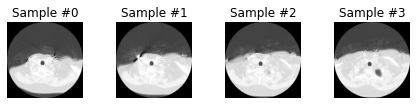

In [ ]:
## plot training example
for i in range(len(covid_dataset_train_val)):
    sample = covid_dataset_train_val[i]
    print(i, sample['image'].shape, sample['percentage'], sample['subject'])
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample['image'].numpy().transpose(1,2,0))
    if i == 3:
        plt.show()
        break

0 torch.Size([3, 512, 512]) drive/MyDrive/DL_Project/Val/Image_0304.png
1 torch.Size([3, 512, 512]) drive/MyDrive/DL_Project/Val/Image_0302.png
2 torch.Size([3, 512, 512]) drive/MyDrive/DL_Project/Val/Image_0303.png
3 torch.Size([3, 512, 512]) drive/MyDrive/DL_Project/Val/Image_0301.png


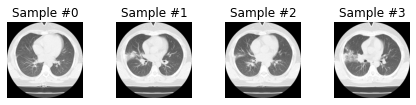

In [ ]:
## plot test examples
for i in range(len(covid_dataset_test)):
    sample = covid_dataset_test[i]
    print(i, sample['image'].shape, sample['img_name'])
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample['image'].numpy().transpose(1,2,0))
    if i == 3:
        plt.show()
        break

In [ ]:
def get_mean_std_value(loader):
    data_sum = torch.tensor([0.0, 0.0, 0.0])
    data_squared_sum = torch.tensor([0.0, 0.0, 0.0])
    num_batches = 0

    for data in loader:
        data_sum += torch.mean(data['image'],dim=[0,2,3]) 
        data_squared_sum += torch.mean(data['image']**2,dim=[0,2,3])  
        num_batches += 1

        if num_batches % 10 == 0:
          print('batch:', num_batches)
          print('mean:',data_sum/num_batches)
          print('std:',(data_squared_sum/num_batches - (data_sum/num_batches)**2)**0.5)

    mean = data_sum/num_batches
    std = (data_squared_sum/num_batches - mean**2)**0.5
    return mean,std



In [ ]:
dl_train = DataLoader(covid_dataset_train_val, batch_size=8, shuffle=True, num_workers=0)
dl_test = DataLoader(covid_dataset_test, batch_size=8, shuffle=True, num_workers=0)
mean,std = get_mean_std_value(dl_train)
mean=[0.4945, 0.4945, 0.4945]
std=[0.3744, 0.3744, 0.3744]

##Split given train set to train & val set

In [ ]:
print(mean,std)

[0.4945, 0.4945, 0.4945] [0.3744, 0.3744, 0.3744]


In [ ]:
import torchvision
import random
random.seed(1)


mean = np.array(mean)
std = np.array(std)

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])



test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])



In [ ]:
covid_dataset_train_val = CovidDataset(csv_file='drive/MyDrive/DL_Project/Train.csv',
                                    root_dir='drive/MyDrive/DL_Project/Train',transform = train_transform)

covid_dataset_test = CovidTestDataset(root_dir='drive/MyDrive/DL_Project/Val', transform = test_transform)

In [ ]:
train_split_neg=list(random.sample(range(0, 248), int(248 * 0.7))) 

train_split_pos=list(random.sample(range(249, 3053), int(2805 * 0.7))) 

val_split_neg=[]
val_split_pos=[]

for i in range(0, 248):
    if i not in train_split_neg:
        val_split_neg.append(i)

for i in range(249, 3053):
    if i not in train_split_pos:
        val_split_pos.append(i)



train_positve = torch.utils.data.Subset(covid_dataset_train_val,train_split_pos )
train_negative = torch.utils.data.Subset(covid_dataset_train_val,train_split_neg )
train_dataset = torch.utils.data.ConcatDataset([train_positve, train_negative])

val_positve = torch.utils.data.Subset(covid_dataset_train_val,val_split_pos )
val_negative = torch.utils.data.Subset(covid_dataset_train_val,val_split_neg )
val_dataset = torch.utils.data.ConcatDataset([val_positve, val_negative])

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=6, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=6, shuffle=True, num_workers=0)

test_dataloader = DataLoader(covid_dataset_test, batch_size=6, shuffle=True, num_workers=0)

In [ ]:
# for batch_idx, sample_batched in enumerate(train_dataloader):
#   image, label = sample_batched['image'], sample_batched['percentage']
#   print(image.size())

## Import pretrained models library

In [ ]:
# ## use imagenet pretrained model
# ## let's start with resnet34
!pip install pretrainedmodels

## Use CUDA to speed up training

In [ ]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
torch.cuda.empty_cache()

## Create Baseline Model

In [ ]:
import pretrainedmodels
#For model building
import torch
from torch import nn, optim
import torchvision
from torch.nn import functional as F

In [ ]:
class CNN1(nn.Module):
    def __init__(self, pretrained=True, pretrianed_model_name="resnet34"):
        super(CNN1, self).__init__()
        if pretrained is True:
            self.model = pretrainedmodels.__dict__[pretrianed_model_name](pretrained="imagenet")
        else:
            self.model = pretrainedmodels.__dict__[pretrianed_model_name](pretrained=None)
        #self.fc1 = nn.Linear(512, 256)

        # for param in self.model.parameters():
        #     param.requires_grad = False

        self.pretrianed_model_name = pretrianed_model_name
        self.conv1 = nn.Conv2d(512, 128, (3,3), stride=1, padding =0)
        self.dropout = nn.Dropout(p=0.5)
        self.conv2 = nn.Conv2d(128, 16, (3,3), stride=1, padding =0)
        self.fc1 = nn.Linear(144, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        bs, _, _, _ = x.shape
        x = self.model.features(x)
        #x = F.adaptive_avg_pool2d(x) #.reshape(bs, -1)
        #x = F.relu(self.fc1(x))
        x = self.conv1(x)
        x = self.dropout(x)
        x = self.conv2(F.relu(x))
        # print(x.size()) # [8, 8, 4, 4]
        x = self.fc1(x.reshape(bs, -1))  # [8, 128]

        label = self.fc2(x)
        return label

    def get_pretrianed_model_name(self):
        return self.pretrianed_model_name

    def get_pretrianed_model_name(self):
        return self.pretrianed_model_name

class CNN2(nn.Module):
    def __init__(self, pretrained=True, pretrianed_model_name="resnet50"):
        super(CNN2, self).__init__()
        if pretrained is True:
            self.model = pretrainedmodels.__dict__[pretrianed_model_name](pretrained="imagenet")
        else:
            self.model = pretrainedmodels.__dict__[pretrianed_model_name](pretrained=None)
        self.pretrianed_model_name = pretrianed_model_name
        self.conv1 = nn.Conv2d(2048, 512, (3,3), stride=1, padding =0)
        self.bn1 = nn.BatchNorm2d(512)
        self.dropout1 = nn.Dropout(p=0.5)
        self.conv2 = nn.Conv2d(512, 128, (3,3), stride=1, padding =0)
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(1152, 512)
        self.dropout3 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 1)
        
    def forward(self, x):
        bs, _, _, _ = x.shape
        x = self.model.features(x)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.bn1(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.dropout2(x)
        # print(x.size()) # [8, 8, 4, 4]
        x = self.fc1(x.reshape(bs, -1))  # [8, 128]
        x = F.relu(x)
        x = self.dropout3(x)
        x = self.fc2(x)
        x = F.relu(x)
        label = self.fc3(x)
        return label

    def get_pretrianed_model_name(self):
        return self.pretrianed_model_name


class CNN3(nn.Module):
    def __init__(self, pretrained=True, pretrianed_model_name="resnet152"):
        super(CNN3, self).__init__()
        if pretrained is True:
            self.model = pretrainedmodels.__dict__[pretrianed_model_name](pretrained="imagenet")
        else:
            self.model = pretrainedmodels.__dict__[pretrianed_model_name](pretrained=None)
        self.pretrianed_model_name = pretrianed_model_name
        self.conv1 = nn.Conv2d(2048, 512, (5,5), stride=1, padding =0)
        self.bn1 = nn.BatchNorm2d(512)
        self.dropout1 = nn.Dropout(p=0.5)
        self.conv2 = nn.Conv2d(512, 128, (5,5), stride=1, padding =0)
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(8192, 1024)
        self.dropout3 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(1024, 128)
        self.fc3 = nn.Linear(128, 1)
        
    def forward(self, x):
        bs, _, _, _ = x.shape
        x = self.model.features(x)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.bn1(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.dropout2(x)
        # print(x.size()) # [8, 8, 4, 4]
        x = self.fc1(x.reshape(bs, -1))  # [8, 128]
        x = F.relu(x)
        x = self.dropout3(x)
        x = self.fc2(x)
        x = F.relu(x)
        label = self.fc3(x)
        return label

    def get_pretrianed_model_name(self):
        return self.pretrianed_model_name


# begin

In [ ]:
def choose_model(chosen_name = 'resnet34'):

    if chosen_name == 'resnet34':
        model_CNN = CNN1(True, chosen_name).to(device)
    elif chosen_name == 'resnet50':
        model_CNN = CNN2(True, chosen_name).to(device)
    elif chosen_name == 'resnet152':
        model_CNN = CNN3(True, chosen_name).to(device)
        
    return model_CNN

In [ ]:
chosen_name = 'resnet152'
model_CNN = choose_model(chosen_name)

In [ ]:
criterion = nn.L1Loss()
#optimizer = optim.SGD(model_CNN.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model_CNN.parameters(), lr=0.0003, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

In [ ]:
# def train_model(model, criterion, optimizer, n_epochs=20):
def train_model(model, criterion, optimizer, n_epochs,train_dataloader,val_dataloader):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    trainloss=[]
    testloss=[]
    for epoch in range(1, n_epochs):
        train_loss = 0.0
        valid_loss = 0.0
        # train the model #
        model.train()
        for batch_idx, sample_batched in enumerate(train_dataloader):
            # importing data and moving to GPU
            image, label = sample_batched['image'].to(device), sample_batched['percentage'].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            output=model(image).reshape(-1)
            # calculate loss
            loss = criterion((output).type(torch.FloatTensor).to(device), label.type(torch.FloatTensor).to(device))
            # back prop
            loss.backward()
            # grad
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            if batch_idx % 100 == 0:
                print('Epoch %d, Batch %d loss: %.6f' %
                  (epoch, batch_idx + 1, train_loss))
        # validate the model #
        model.eval()
        for batch_idx, sample_batched in enumerate(val_dataloader):
            image, label = sample_batched['image'].to(device), sample_batched['percentage'].to(device)  
            output = model(image).reshape(-1)
            # calculate loss
            loss=criterion((output).type(torch.FloatTensor).to(device), label.type(torch.FloatTensor).to(device))
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
        
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, valid_loss))
        
        trainloss.append(train_loss)
        testloss.append(valid_loss)               
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model, 'drive/MyDrive/DL_Project/model_' + model.get_pretrianed_model_name() + '.pt')
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            valid_loss_min = valid_loss
    # return trained model
    # return (model, trainloss, testloss)
    return model

In [ ]:
# model_conv = train_model(model_CNN, criterion, optimizer, n_epochs=25)
from sklearn.model_selection import KFold
import numpy as np
splits=KFold(n_splits=10,shuffle=True,random_state=42)
foldperf={}
n_epochs = 25

for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(covid_dataset_train_val)))):

    print('Fold {}'.format(fold + 1))
    model = model_CNN
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(covid_dataset_train_val, batch_size=8, sampler=train_sampler)
    val_loader = DataLoader(covid_dataset_train_val, batch_size=8, sampler=val_sampler)
    model= train_model(model,criterion, optimizer, n_epochs, train_loader, val_loader)

torch.save(model,'k_cross_CNN.pt')   

Epoch 1, Batch 1 loss: 19.711462
Epoch 1, Batch 101 loss: 14.506065
Epoch 1, Batch 201 loss: 13.014511
Epoch 1, Batch 301 loss: 12.112564
Epoch: 1 	Training Loss: 11.484762 	Validation Loss: 6.628340
Validation loss decreased (inf --> 6.628340).  Saving model ...
Epoch 2, Batch 1 loss: 4.514096
Epoch 2, Batch 101 loss: 9.110781
Epoch 2, Batch 201 loss: 8.708406
Epoch 2, Batch 301 loss: 8.907103
Epoch: 2 	Training Loss: 8.750656 	Validation Loss: 7.058897
Epoch 3, Batch 1 loss: 3.230065
Epoch 3, Batch 101 loss: 7.174019
Epoch 3, Batch 201 loss: 7.923309
Epoch 3, Batch 301 loss: 7.904830
Epoch: 3 	Training Loss: 7.806810 	Validation Loss: 9.033959
Epoch 4, Batch 1 loss: 4.380039
Epoch 4, Batch 101 loss: 6.782739
Epoch 4, Batch 201 loss: 6.821428
Epoch 4, Batch 301 loss: 7.102305
Epoch: 4 	Training Loss: 7.100327 	Validation Loss: 5.261479
Validation loss decreased (6.628340 --> 5.261479).  Saving model ...
Epoch 5, Batch 1 loss: 2.194548
Epoch 5, Batch 101 loss: 6.642139
Epoch 5, Batch 2

In [ ]:
print(model_CNN)

In [ ]:
trainloss=[]
testloss=[]
for i in model_conv[1]:
    trainloss.append(i.tolist())
for i in model_conv[2]:
    testloss.append(i.tolist())

In [ ]:
import matplotlib.pyplot as plt

plt.style.use('seaborn')

plt.plot(range(1,25), trainloss, label = 'Training error')
plt.plot(range(1,25), testloss, label = 'Validation error')
plt.ylabel('Loss', fontsize = 14)
plt.xlabel('Epochs', fontsize = 14)
plt.title('Learning curves', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0,40)

## Save result on Actual Val Data to csv File

In [ ]:

# PATH = 'drive/MyDrive/DL_Project/model_resnet50.pt'
# model = torch.load(PATH)

In [ ]:
df = pd.DataFrame(columns=['image_name','output'])
for batch_idx, sample_batched in enumerate(test_dataloader):
    image= sample_batched['image'].to(device)
    img_name= sample_batched['img_name']
    output = model_conv[0](image).type(torch.LongTensor).reshape(-1)
    img_name = np.array(img_name).reshape(output.shape[0],1)
    o = output.cpu().data.numpy().reshape(output.shape[0],1)
    a = np.concatenate((img_name,o),axis=1)
    df = df.append(pd.DataFrame(a, columns=df.columns), ignore_index=True)
    

In [ ]:
#Extracting image name from the image path
df['image_name']=df['image_name'].str.split("/").str[-1]

In [ ]:
df.to_csv('drive/MyDrive/DL_Project/predictions.csv', index=False, header=False)

In [ ]:
len(df)

## Points to note:

General Rules: Participants should estimate the percentage of Covid-19 infection from each slice using Machine Learning. **Only ImageNet's pre-trained models and Lung Nodule Segmentation models are allowed**. The use of external data or other pre-trained models is not allowed. The models must be trained using the training data and evaluated using the validation data.

##Things you can try:

- The dataset is not as big and especially negative covid images are very few.
It would be better to use k-fold cross validation rather than conventional splitting.
- How would you split image splices from the same patient subject into train & val set?
- How would the information on the patient (subject #) help your prediction?
- What kind of preprocessing/data augmentation method help your model? What kind of methods would actually make your model perform worse?
- What other different CNN architectures could you explore to acheive lower MAE?
- Explore different optimizers, loss combinations, etc
- Explore different regularization methods

This is no way an exhaustive list. You might get a better idea by reading relevant research papers. Good luck!